In [1]:
import scipy.io
import numpy as np 
import os 
import scipy.misc 
import matplotlib.pyplot as plt 
import tensorflow as tf
%matplotlib inline  

def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net, mean_pixel

def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)
def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
def preprocess(image, mean_pixel):
    return image - mean_pixel
def unprocess(image, mean_pixel):
    return image + mean_pixel

[1/3] relu2_1
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 513, 684, 128)
[2/3] relu3_1
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 257, 342, 256)
[3/3] relu4_1
 Type of 'features' is  <type 'numpy.ndarray'>
 Shape of 'features' is (1, 129, 171, 512)

___.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


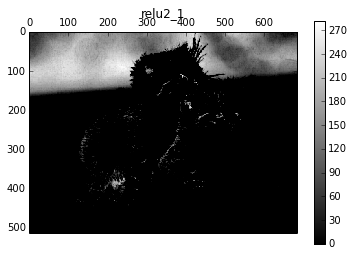

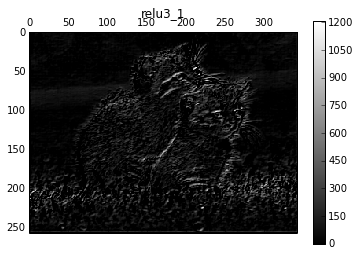

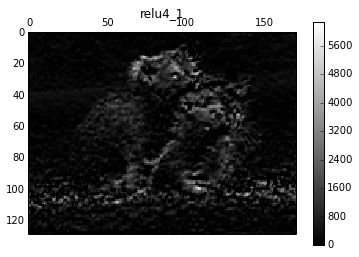

In [3]:
def imread(path):
    return scipy.misc.imread(path).astype(np.float)
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
        
cwd  = os.getcwd()
VGG_PATH = cwd + "/data/imagenet-vgg-verydeep-19.mat"
IMG_PATH = cwd + "/images/cat.jpg"
input_image = imread(IMG_PATH)
shape = (1,) + input_image.shape # (h, w, nch) =>  (1, h, w, nch)
with tf.Graph().as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net, mean_pixel = net(VGG_PATH, image)
    input_image_pre = np.array([preprocess(input_image, mean_pixel)])
    # layers = all_layers # For all layers 
    layers = ('relu2_1', 'relu3_1', 'relu4_1')
    for i, layer in enumerate(layers):
        print "[%d/%d] %s" % (i+1, len(layers), layer)
        features = net[layer].eval(feed_dict={image: input_image_pre})
        print " Type of 'features' is ", type(features)
        print " Shape of 'features' is %s" % (features.shape,)
        # Plot response 
        if 1:
            plt.figure(i+1)
            plt.matshow(features[0, :, :, 0], cmap=plt.cm.gray, fignum=i+1)
            plt.title("" + layer)
            plt.colorbar()
print "\n___."
plt.show()
